In [1]:
!cat ../configs/t1_resnet34.config

[FASHION-RESNET34]
# Training Related
NUM_EPOCHS = 15
NUM_CLASSES = 19
BATCH_SIZE = 128
SNAPSHOT_STEPS = 500
VALIDATION_STEPS = 100
LEARNING_RATE = 0.003
USE_L2 = True
WEIGHT_DECAY = 1e-4

SNAPSHOT_DIR = /home/step/Personal/UCH/2021-sem1/VisionComp/t1/snapshots-r34/

# Dataset Related
DATA_DIR = /home/step/Personal/UCH/2021-sem1/VisionComp/t1/data/clothing-small/
SHUFFLE_SIZE = 10000
CHANNELS = 3
IMAGE_TYPE = FASHION
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

#for tf_records to use multithreads
USE_MULTITHREADS = TRUE
NUM_THREADS = 10

#CKPFILE is used for fine tunning
#CKPFILE =/home/step/Personal/UCH/2021-sem1/VisionComp/t1/chks


In [2]:
!ls /home/step/Personal/UCH/2021-sem1/VisionComp/t1/data/clothing-small/

mapping.txt  test_sample  test_sample.txt  train_sample  train_sample.txt


In [3]:
!head /home/step/Personal/UCH/2021-sem1/VisionComp/t1/data/clothing-small/train_sample.txt

train_sample/46df173e-de46-4d17-8.png	5
train_sample/3ef50222-a62f-4b46-8.png	6
train_sample/f3a6b23d-9336-430c-8.png	3
train_sample/1e0e5a3d-9940-43d9-9.png	1
train_sample/9ebd6bde-2407-4b2b-8.png	3
train_sample/28ae378b-9177-407f-b.png	7
train_sample/5690784a-74fd-4828-a.png	8
train_sample/aa68d992-0aaa-41c8-b.png	0
train_sample/5508b9b8-33aa-416e-a.png	0
train_sample/9bc7ecb7-5949-4bb5-8.png	6


In [4]:
!head /home/step/Personal/UCH/2021-sem1/VisionComp/t1/data/clothing-small/test_sample.txt

test_sample/c72f067e-5e18-404f-a.png	5
test_sample/2c475ee6-8b2d-4ee5-b.png	9
test_sample/70062468-694d-40f3-b.png	15
test_sample/29595465-6595-4b9c-8.png	15
test_sample/a8c7b47f-ea6b-433e-b.png	0
test_sample/c810ffdf-1700-495a-a.png	18
test_sample/4e51ee98-db8a-4c53-a.png	18
test_sample/d621d57a-3336-44a8-9.png	16
test_sample/ae0f296d-5dc9-4740-9.png	14
test_sample/f48d0e7c-c42f-4c39-8.png	7


## DATA DIR

In [5]:
from pathlib import Path

import numpy as np

DATA_DIR = Path("/home/step/Personal/UCH/2021-sem1/VisionComp/t1/data/clothing-small")

## Parse mapping

In [6]:
def parse_mapping(data_pth):
    mapping_pth = list(data_pth.glob('mapping*txt'))
    
    if len(mapping_pth) > 1:
        raise ValueError("There's more than one mapping.txt")
    else:
        mapping_pth = mapping_pth[0]
    
    encoding_to_label = dict()
    
    with open(mapping_pth) as mapping_txt:
        for line in mapping_txt:
            label, code = [i.strip() for i in line.strip().split('\t')] 
            
            encoding_to_label[code] = label
    
    return encoding_to_label

label_encoding = parse_mapping(DATA_DIR)
label_encoding, len(label_encoding)

({'0': 'shorts',
  '1': 'jackets_parka',
  '2': 'sweater',
  '3': 'skirts',
  '4': 'dress',
  '5': 'blouse_shirts',
  '6': 'tee',
  '7': 'pants',
  '8': 'shoes',
  '9': 'belt',
  '10': 'coat',
  '11': 'scarf',
  '12': 'bag',
  '13': 'socks',
  '14': 'jumper',
  '15': 'blazer',
  '16': 'hat',
  '17': 'glasses',
  '18': 'tights'},
 19)

## Parse .txt, get_indexes, get_labels

In [7]:
def parse_txt(data_pth):
    train_txt_pth = list(data_pth.glob('train*txt'))
    test_txt_pth = list(data_pth.glob('test*txt'))

    if len(train_txt_pth) > 1 or len(test_txt_pth) > 1:
        raise ValueError("There's more than one .txt for Train or Test.")
    else:
        train_txt_pth = train_txt_pth[0]
        test_txt_pth = test_txt_pth[0]


    # use lists to manage indexes easier
    train_pth_label = [] 
    test_pth_label = []

    with open(train_txt_pth) as train_txt:
        for line in train_txt:
            pth, label = [i.strip() for i in line.strip().split('\t')]

            train_pth_label.append((pth, label)) 

    with open(test_txt_pth) as test_txt:
        for line in test_txt:
            pth, label = [i.strip() for i in line.strip().split('\t')]

            test_pth_label.append((pth, label)) 
    
    return train_pth_label, test_pth_label

def get_indexes(train, test=None):
    # get train/test indexes
    train_indexes = np.arange(len(train))
    
    if test is not None:
        test_indexes = np.arange(len(test))
        return train_indexes, test_indexes
    
    return train_indexes

def get_files(train, test=None, data_pth=None):
    base_pth = Path('.')
    if data_pth is not None:
        base_pth = data_pth
    
    train_files = [base_pth / pth for pth, label in train]
    
    if test is not None:
        test_files = [base_pth / pth for pth, label in test]
        return train_files, test_files
    
    return train_files

def get_labels(train, test=None):
    train_labels = [label for pth, label in train]
    
    if test is not None:
        test_labels = [label for pth, label in test]
        return train_labels, test_labels
    
    return train_labels

### Use the funcs

In [8]:
train_pth_label, test_pth_label = parse_txt(DATA_DIR)

train_files, test_files = get_files(train_pth_label, test_pth_label, DATA_DIR)
train_labels, test_labels = get_labels(train_pth_label, test_pth_label)

train_indexes = get_indexes(train_labels)
test_indexes = get_indexes(test_labels)

### Show ten images for train and test respectively 

Training (189, 126, 3) shape
Test (110, 187, 3) shape


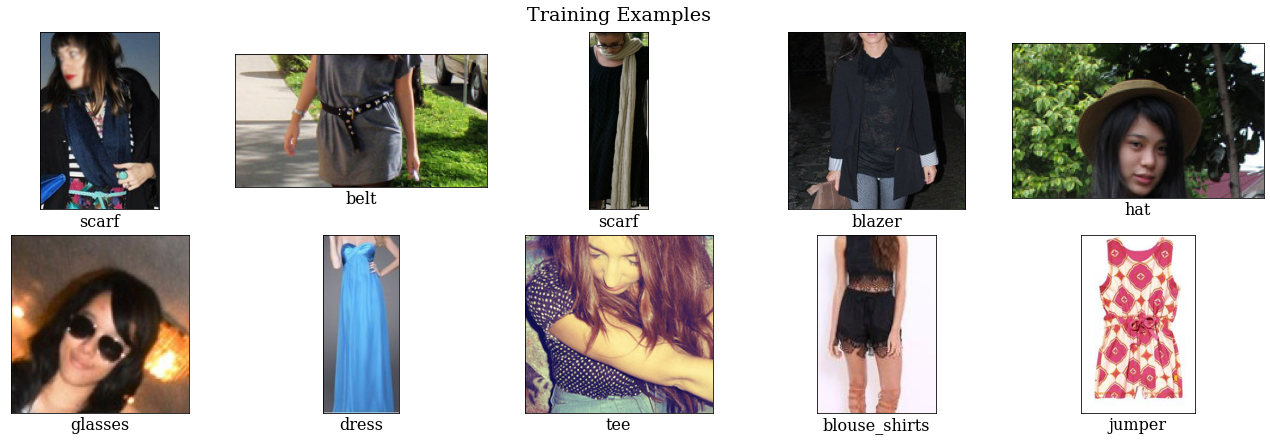

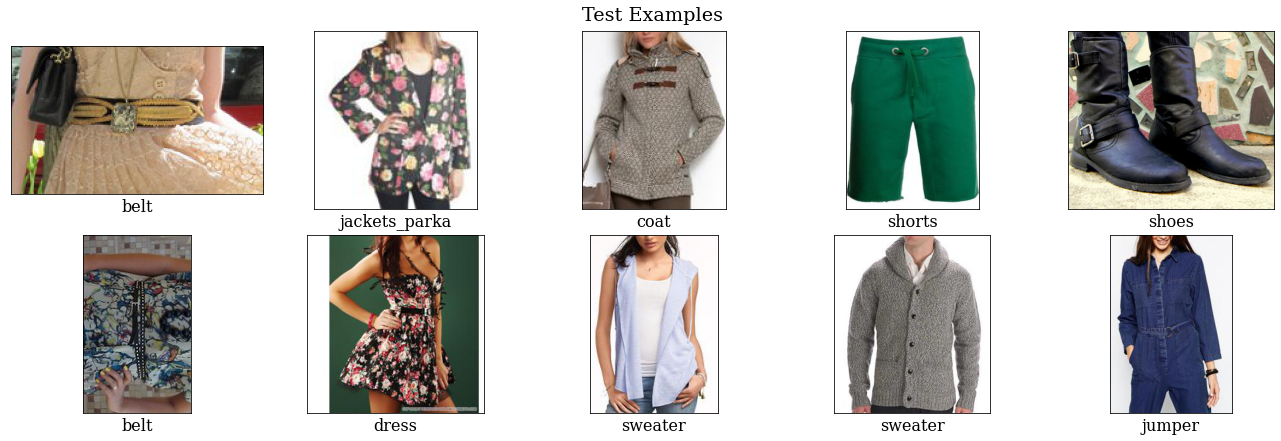

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size='16')
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')


n = 10

figure_pth = Path.cwd() / 'figures'
figure_pth.mkdir(exist_ok=True)

for train_test, indexes_array in enumerate([train_indexes, test_indexes]):
    if train_test == 0:
        pth_label = train_pth_label
        title = 'Training'
        f_save = 'train_examples.pdf'
    else:
        pth_label = test_pth_label
        title = 'Test'
        f_save = 'test_examples.pdf'
    
    show_idx = np.random.choice(indexes_array, size=n)
    
    f, axs = plt.subplots(nrows=2, ncols=n//2, figsize=(18,6), constrained_layout=True)
    
    first = 1
    for ax, idx in zip(axs.flatten(), show_idx):
        pth, label = pth_label[idx]
        im = np.array(plt.imread(DATA_DIR / pth))
        
        if first:
            print(f'{title} {im.shape} shape')
            first = 0
        
        ax.imshow(im)
        ax.set_xlabel(f'{label_encoding[label]}')
        ax.set_yticks([])
        ax.set_xticks([])
    
    f.suptitle(f'{title} Examples')
    f.savefig(figure_pth / f_save)

## Open files

In [10]:
import tensorflow as tf
import concurrent.futures

def split_list(lst, n):
    k, m = divmod(len(lst), n)
    return (lst[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def imgs_to_array(pths, base_pth, load_kwargs={}, thread_idx=None):
    imgs_list = []
    for pth in pths:
        img = tf.keras.preprocessing.image.load_img(base_pth / pth, **load_kwargs)
        img_arr = tf.keras.preprocessing.image.img_to_array(img)
        imgs_list.append(img_arr)
    if thread_idx is not None:
        return np.array(imgs_list), thread_idx
    return np.array(imgs_list)


def threaded_func(func, num_workers, parts, func_kwargs={}, verbose=False):
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_res = []
        
        for thread_idx, part in enumerate(parts):
            
            func_kwargs['thread_idx'] = thread_idx
            future_to_res.append(executor.submit(func, part, **func_kwargs))
            
            if verbose:
                print(f"Launched thread {thread_idx}")

        thread_results = [None] * num_workers
        for future in concurrent.futures.as_completed(future_to_res):
            result = future.result()
            result, thread_idx = result[0], result[1]                
            thread_results[thread_idx] = result 
            
            if verbose:
                print(f"Joined thread {thread_idx}")
        
        return thread_results
        

def get_arrays(train_pths, test_pths=None, data_pth=None, load_kwargs={}, num_workers=1, verbose=False):
    base_pth = Path('.')
    if data_pth is not None:
        base_pth = data_pth
    
    if num_workers > 1:
        train_parts = split_list(train_pths, num_workers)
        imgs_to_array_kwargs = {
            'base_pth' : base_pth,
            'load_kwargs' : load_kwargs
        }
        
        train = threaded_func(
            imgs_to_array, 
            num_workers, 
            train_parts,
            imgs_to_array_kwargs
        )
        
        if verbose:
            print("Threads returned")

        train = np.concatenate(train, axis=0)
        
        if verbose:
            print("Train concatened")
        
    else:
        train = imgs_to_array(train_pths, base_pth, load_kwargs)
        
    if test_pths is not None:
        if num_workers > 1 :
            test_parts = split_list(test_pths, num_workers)
            imgs_to_array_kwargs = {
                'base_pth' : base_pth,
                'load_kwargs' : load_kwargs
            }

            test = threaded_func(
                imgs_to_array, 
                num_workers, 
                test_parts,
                imgs_to_array_kwargs
            )

            if verbose:
                print("Threads returned")

            test = np.concatenate(test, axis=0)
            
            if verbose:
                print("Test concatened")
        else:
            test = imgs_to_array(test_pths, base_pth, load_kwargs)
        return train, test
    return train


# x_train, x_test = get_arrays(
#     train_files, 
#     test_files,
#     load_kwargs={'target_size': (224, 224)},
#     num_workers=10,
# )


# print(x_train.shape, x_test.shape)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Create TensorFlow Dataset

See https://keras.io/api/preprocessing/image/#imagedatagenerator-class (old)

See https://cs230.stanford.edu/blog/datapipeline/#an-overview-of-tfdata

In [11]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

def parse_function(filename, label, target_size=224):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)

    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    resized_image = tf.image.resize(image, [target_size, target_size])
    return resized_image, label

def train_preprocess(image, label, seed, target_size=224):
    image = tf.image.central_crop(image, central_fraction = 0.7)
    
    # Make a new seed
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    
    # Back to the original size
    image = tf.image.resize(image, size=[target_size, target_size])
    
    image = tf.image.stateless_random_flip_left_right(image, seed=new_seed)

    image = tf.image.stateless_random_brightness(
        image, max_delta=32.0 / 255.0, seed=new_seed)
    image = tf.image.stateless_random_saturation(
        image, lower=0.5, upper=1.5, seed=new_seed)

    #Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

### Train

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices(
    ([str(fname) for fname in train_files], train_labels)
)

process_func = lambda img, label : train_preprocess(img, label, seed=[8, 8])

train_ds = train_ds.shuffle(len(train_files))
train_ds = train_ds.map(parse_function, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(process_func, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.batch(64)
train_ds = train_ds.prefetch(1)

### Test

In [13]:
test_ds = tf.data.Dataset.from_tensor_slices(
    ([str(fname) for fname in test_labels], test_labels)
)
test_ds = test_ds.map(parse_function, num_parallel_calls=AUTOTUNE)

test_ds = test_ds.batch(64)
test_ds = test_ds.prefetch(1)

### As a script

In [14]:
if Path.cwd().parent.stem == 't1':
    %cd ..

/home/step/Personal/UCH/2021-sem1/VisionComp/t1


In [15]:
from dataset import ClothingSmall

csDataset = ClothingSmall(data_dir = DATA_DIR)

csDataset.prepare()

csDataset.make_ds(parse_function, process_func)

In [16]:
csDataset.train_ds, csDataset.test_ds

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 19)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 19)), types: (tf.float32, tf.float32)>)

In [17]:
for x, y in csDataset.train_ds:
    break

### Test with a model

In [23]:
# model = tf.keras.Seq

## Create TFRecords

#### TODO. But isn't a requirement...